In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lightgbm as lgb
import catboost as cb
from keras.wrappers.scikit_learn import KerasRegressor
from keras import Sequential
from keras.layers import Dense

from tsfresh.examples import load_robot_execution_failures
from tsfresh import extract_features, select_features
import optuna

from common import EP
from models import *
from dfdb import DFDB

import types
import os
import copy

import seaborn as sns
import matplotlib.pyplot as plt

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# os.environ["CUDA_VISIBLE_DEVICES"]="3";  

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_colwidth', -1)

In [3]:
%%HTML
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 65%; }
   div#maintoolbar-container { width: 99%; }
</style>

In [46]:
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)
# pd.set_option('display.width', 2000)
# pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.max_colwidth', -1)

In [4]:
def m_lineplot(dflist, plot_features=None, n_col=3):

    
    n_chart = len(dflist)
    n_row = int(n_chart/n_col) if n_chart % n_col == 0 else n_row+1
        
    fig = plt.figure(figsize=(5*n_col, 3*n_row))
    for i, df in enumerate(dflist):
        ax = fig.add_subplot(n_row, n_col, i+1)
        if type(plot_features) == type(None):
            plot_features = df.columns.tolist()
        for feat in plot_features:
            sns.lineplot(x=df.index, y=df[feat], ax=ax)
    return 

In [5]:
df_train = pd.read_pickle('../feats/df_train.pkl')
df_test = pd.read_pickle('../feats/df_test.pkl')

In [6]:
df_train['label'] = df_train['y'].apply(lambda x:  int(x) if x<15 else 15)
group = df_train['season'].values
group[np.where(group==17)[0]] = 1
df_train['group'] = group
df_train = df_train.drop(columns=['season'])

In [7]:
test_X = df_train.drop(columns=['y','index','group','label']).copy()
test_X.index = df_train['index']
test_y = df_train['y'].copy()
test_y.index = df_train['index']
tsfresh_columns = select_features(test_X, test_y).columns.tolist()

In [8]:
original_columns = df_train.columns.drop(['index','y','label','group']).tolist()

In [9]:
catboost_columns = ['spkt_welch_density__coeff_3',
 'spkt_welch_densitycoeff_2',
 'abs_q25_5',
 'abs_q75_6',
 'q05_roll_std_1000',
 'abs_q75_7',
 'abs_q95_2',
 'q05_5',
 'abs_q75_2',
 '5000skewness_max_',
 'fft_coefficientcoeff_80__attr_"imag"',
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 '5000kurtosis_mean_',
 "number_peaks{'n': 1}",
 '5000smoothness_entropy_',
 'ave10_7',
 'q75_roll_std_1000',
 'FFT_Mag_25q0',
 'fft_coefficientcoeff_20__attr_"abs"']
lgbm_columns = ['q25_roll_std_100',
 'abs_q25_5',
 'spkt_welch_density__coeff_3',
 'abs_q75_6',
 'abs_q75_7',
 'spkt_welch_densitycoeff_2',
 'median__roll_std',
 'abs_q01_5',
 '5000smoothness_quantile05',
 '5000smoothness_std_',
 'abs_q95_3',
 'FFT_Mag_75q0',
 '5000median_std_',
 'spkt_welch_density__coeff_17']
xgbm_columns = ['q25_roll_std_100',
 'abs_q25_5',
 'spkt_welch_density__coeff_3',
 'abs_q75_7',
 'spkt_welch_densitycoeff_2',
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'agg_autocorrelationf_agg_"mean"__maxlag_40',
 "number_peaks{'n': 1}",
 '5000peak_peak_amp_max_',
 'abs_q95_3',
 'spkt_welch_density__coeff_89',
 'abs_q05_2']
randomforest_randomforest = ['abs_q25_5', 'abs_q01_4', 'q25_roll_std_100']
extratrees_columns = ['q05_2',
 "number_peaks{'n': 1}",
 'abs_q01_6',
 'abs_q95_2',
 '5000smoothness_quantile25',
 '5000std_median_',
 '5000smoothness_median_',
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'abs_q75_6',
 "number_peaks{'n': 3}",
 'q75_roll_std_10',
 "number_peaks{'n': 10}",
 '5000min_quantile75',
 '5000smoothness_quantile05',
 "number_peaks{'n': 5}",
 'abs_q01_2',
 '5000smoothness_mean_',
 'min_roll_std_100',
 'abs_q05_2',
 'q01_roll_std_1000']
gradientboosting_columns = ['q05_5',
 'kurt_1',
 'abs_q75_6',
 'abs_q75_7',
 'spkt_welch_density__coeff_28',
 'spkt_welch_density__coeff_99',
 'fft_coefficientcoeff_6__attr_"abs"',
 '5000smoothness_quantile05',
 'q25_roll_std_100',
 'spkt_welch_densitycoeff_2',
 'abs_max_1',
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'abs_q25_5',
 'abs_q01_7',
 'q05_8',
 'Hilbert_mean_6',
 'abs_q95_2',
 '5000skewness_max_',
 '5000kurtosis_mean_',
 'spkt_welch_density__coeff_3']

In [10]:
all_columns = catboost_columns+lgbm_columns+xgbm_columns+randomforest_randomforest+extratrees_columns+gradientboosting_columns
unique_columns = list(set(all_columns))
common_columns = []
common_columns50 = []
common_columns75 = []
common_columns95 = []
N_columns = 6
count_values = [all_columns.count(col) for col in unique_columns]
for col in unique_columns:
    if all_columns.count(col)==N_columns:
        common_columns.append(col)
    if all_columns.count(col)>=np.quantile(count_values, .5):
        common_columns50.append(col)
    if all_columns.count(col)>=np.quantile(count_values, .75):
        common_columns75.append(col)
    if all_columns.count(col)>=np.quantile(count_values, .95):
        common_columns95.append(col)
print('unique_columns ',len(unique_columns))
print('common_columns50 ',len(common_columns50))
print('common_columns75 ',len(common_columns75))
print('common_columns95 ',len(common_columns95))
print('common_columns ',len(common_columns))

unique_columns  55
common_columns50  55
common_columns75  15
common_columns95  7
common_columns  0


In [11]:
db = DFDB('../trial/kerasmlp.pkl', auto_commit=False)
df_trial = db.select()

In [13]:
df_trial['kfold-type'] = df_trial['param'].apply(lambda x: x['kfold']['type'])
df_trial['algorithm-init'] = df_trial['param'].apply(lambda x: x['algorithm']['init'])
df_trial[['datetime','nfeatures', 'kfold-type', 'algorithm-init', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff', 'remark']]

,datetime,nfeatures,kfold-type,algorithm-init,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff,remark
0,2019-05-16 06:55:20.008242,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[1024, 1024, 256, 16],activation='relu',l1l2regularizer=0.01,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [1024, 1024, 256, 16], 'activation': 'relu', 'l1l2regularizer': 0.01, 'dropout': 0.3}",3.029792,0.000091,3.029836,0.000359,0.000044,None
1,2019-05-16 10:21:58.948983,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[1024, 1024, 256, 16],activation='relu',l1l2regularizer=0.1,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [1024, 1024, 256, 16], 'activation': 'relu', 'l1l2regularizer': 0.1, 'dropout': 0.3}",3.029836,0.000093,3.029870,0.000355,0.000034,None
2,2019-05-16 11:34:31.195248,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[1024, 1024, 256, 16],activation='relu',l1l2regularizer=1,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [1024, 1024, 256, 16], 'activation': 'relu', 'l1l2regularizer': 1, 'dropout': 0.3}",3.030027,0.000095,3.030167,0.000349,0.000140,None
3,2019-05-17 00:36:52.261097,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[1024, 1024, 256, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [1024, 1024, 256, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",0.454774,0.000280,0.949574,0.000443,0.494800,None
4,2019-05-17 02:54:07.726431,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[1024, 256, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [1024, 256, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",0.608211,0.000163,1.134777,0.000121,0.526565,None
5,2019-05-17 05:12:28.236277,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[512, 512, 256, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [512, 512, 256, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",0.636796,0.000058,1.131104,0.000095,0.494308,None
6,2019-05-17 06:30:23.637812,165,,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[2048, 2048, 256, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [2048, 2048, 256, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",0.398893,0.001634,0.877269,0.000888,0.478376,None
7,2019-05-17 08:19:37.214268,165,stratified,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[2048, 2048, 256, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [2048, 2048, 256, 16], 'activation': 'relu', 'l1l2regularizer': Non

In [38]:
def revert_krfe(df_train, param, sorted_columns, df_test, trial, start_columns, limit=None, remark=None, verbose=0):
    
        # init cv_score and try only base feature
        selected_columns = copy.deepcopy(start_columns)
        if type(limit) == type(None):
            limit = len(sorted_columns)
        args = copy.deepcopy(param)
        args['columns'] = selected_columns
        args['algorithm']['init']['input_dim'] = len(args['columns'])
        df_his,  df_feature_importances, df_valid_pred, df_test_pred =  EP.process(df_train, args, df_test = df_test, trial=trial, remark=remark)
        val_mae_mean = np.mean(df_his.valid)
        cv_score = val_mae_mean


        # add feature one by one and check cv score change
        for idx,col in enumerate(sorted_columns):
    #         if idx in start_column_index:
    #             continue
            args = copy.deepcopy(param)
            args['columns'] = list(set(selected_columns + [col]))
            args['algorithm']['init']['input_dim'] = len(args['columns'])
            df_his,  df_feature_importances, df_valid_pred, df_test_pred =  EP.process(df_train, args, df_test = df_test, trial=trial, remark=remark)
            val_mae_mean = np.mean(df_his.valid)

            if val_mae_mean < cv_score:
                selected_columns.append(col)
                cv_score = val_mae_mean
                if verbose>0:
                    print(col, 'improved')
            else:
                if verbose>0:
                    print(col, 'not improved')
            if len(selected_columns) >= limit:
                break

        return selected_columns

In [39]:
path_param={
    'hidden_layer_sizes':[64, 16],
    'activation':'relu',
    'l1l2regularizer':None,
    'dropout':.3,
}
base_save_dir = create_path('KerasMLPRegressor', path_param)
param={
    'algorithm': {
        'cls': 'KerasMLPRegressor',
        'fit': {
            'versbose':0, 
            'epochs':50, 
            'eval_set':{},
        },
        'init': {
            'input_dim':len(common_columns50),
            'batch':128, 
            'solver':'adam', 
            'metric':'mean_absolute_error', 
            'lr':.0001, 
            'sgd_momentum':.9, 
            'sgd_decay':0.0001,
            'base_save_dir':base_save_dir, 
            'alias':'kerasmlp',
            **path_param
        }
    },
    'columns': common_columns50,
    'kfold': {
        'n_splits': 3,
        'random_state': 1985,
        'shuffle': True,
        'type': 'group'#stratified
    },
    'scaler': {
        'cls': 'StandardScaler',
        'init':{}
    }
}

In [40]:
mytrial = []
selected_columns = revert_krfe(df_train, param, unique_columns, df_test, mytrial, common_columns95, limit=20, remark='start from top1 column', verbose=1)

In [45]:
print(len(selected_columns))
selected_columns

14


['q25_roll_std_100',
 'spkt_welch_densitycoeff_2',
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'abs_q75_7',
 'abs_q25_5',
 'spkt_welch_density__coeff_3',
 'abs_q75_6',
 'q01_roll_std_1000',
 'Hilbert_mean_6',
 'abs_q95_2',
 'FFT_Mag_75q0',
 'abs_q01_5',
 'spkt_welch_densitycoeff_2',
 '5000std_median_']

In [57]:
selected_columns = ['abs_q75_7',
 'abs_q25_5',
 'FFT_Mag_75q0',
 'q01_roll_std_1000',
 'abs_q01_5',
 'Hilbert_mean_6',
 '5000std_median_',
 'spkt_welch_densitycoeff_2',
 'spkt_welch_density__coeff_3',
 'abs_q75_6',
 'q25_roll_std_100',
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'abs_q95_2']

In [42]:
for trial_i in mytrial:
    db.insert(trial_i)
db.commit()

In [62]:
# run one try

path_param={
    'hidden_layer_sizes':[64, 64, 64, 16],
    'activation':'relu',
    'l1l2regularizer':None,
    'dropout':.3,
}
base_save_dir = create_path('KerasMLPRegressor', path_param)
param={
    'algorithm': {
        'cls': 'KerasMLPRegressor',
        'fit': {
            'versbose':0, 
            'epochs':50, 
            'eval_set':{},
        },
        'init': {
            'input_dim':len(df_trial.loc[65]['param']['columns']),
            'batch':128, 
            'solver':'adam', 
            'metric':'mean_absolute_error', 
            'lr':.0001, 
            'sgd_momentum':.9, 
            'sgd_decay':0.0001,
            'base_save_dir':base_save_dir, 
            'alias':'kerasmlp',
            **path_param
        }
    },
    'columns': selected_columns,
    'kfold': {
        'n_splits': 3,
        'random_state': 1985,
        'shuffle': True,
        'type': 'group'#stratified
    },
    'scaler': {
        'cls': 'StandardScaler',
        'init':{}
    }
}

mytrial = []
df_his,  df_feature_importances, df_valid_pred, df_test_pred =  EP.process(df_train, param, df_test = df_test, trial=mytrial)
db.insert(mytrial[0])
df_trial = db.select()

In [64]:
df_trial = db.select()
df_trial['kfold-type'] = df_trial['param'].apply(lambda x: x['kfold']['type'])
df_trial['algorithm-init'] = df_trial['param'].apply(lambda x: x['algorithm']['init'])
df_trial[['datetime','nfeatures', 'kfold-type', 'algorithm-init', 'train_mae','train_mae_var','val_mae','val_mae_var','mae_diff']]

,datetime,nfeatures,kfold-type,algorithm-init,train_mae,train_mae_var,val_mae,val_mae_var,mae_diff
0,2019-05-16 06:55:20.008242,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[1024, 1024, 256, 16],activation='relu',l1l2regularizer=0.01,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [1024, 1024, 256, 16], 'activation': 'relu', 'l1l2regularizer': 0.01, 'dropout': 0.3}",3.029792,0.000091,3.029836,0.000359,0.000044
1,2019-05-16 10:21:58.948983,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[1024, 1024, 256, 16],activation='relu',l1l2regularizer=0.1,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [1024, 1024, 256, 16], 'activation': 'relu', 'l1l2regularizer': 0.1, 'dropout': 0.3}",3.029836,0.000093,3.029870,0.000355,0.000034
2,2019-05-16 11:34:31.195248,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[1024, 1024, 256, 16],activation='relu',l1l2regularizer=1,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [1024, 1024, 256, 16], 'activation': 'relu', 'l1l2regularizer': 1, 'dropout': 0.3}",3.030027,0.000095,3.030167,0.000349,0.000140
3,2019-05-17 00:36:52.261097,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[1024, 1024, 256, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [1024, 1024, 256, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",0.454774,0.000280,0.949574,0.000443,0.494800
4,2019-05-17 02:54:07.726431,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[1024, 256, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [1024, 256, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",0.608211,0.000163,1.134777,0.000121,0.526565
5,2019-05-17 05:12:28.236277,165,,"{'batch': 32, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[512, 512, 256, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [512, 512, 256, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",0.636796,0.000058,1.131104,0.000095,0.494308
6,2019-05-17 06:30:23.637812,165,,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.0001, 'sgd_momentum': 0.9, 'sgd_decay': 1e-05, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[2048, 2048, 256, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [2048, 2048, 256, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",0.398893,0.001634,0.877269,0.000888,0.478376
7,2019-05-17 08:19:37.214268,165,stratified,"{'batch': 128, 'solver': 'adam', 'metric': 'mean_absolute_error', 'lr': 0.001, 'sgd_momentum': 0.9, 'sgd_decay': 0.0001, 'base_save_dir': 'KerasMLPRegressor/input_dim=165,hidden_layer_sizes=[2048, 2048, 256, 16],activation='relu',l1l2regularizer=None,dropout=0.3', 'alias': 'kerasmlp', 'input_dim': 165, 'hidden_layer_sizes': [2048, 2048, 256, 16], 'activation': 'relu', 'l1l2regularizer': None, 'dropout': 0.3}",0.643691,0.000572,1.05

In [67]:
df_his_list = [pd.read_csv(param['algorithm']['init']['base_save_dir'] + '/{}_{}_train_his.csv'.format(param['algorithm']['init']['alias'], i), index_col=0) for i in range(param['kfold']['n_splits'])]

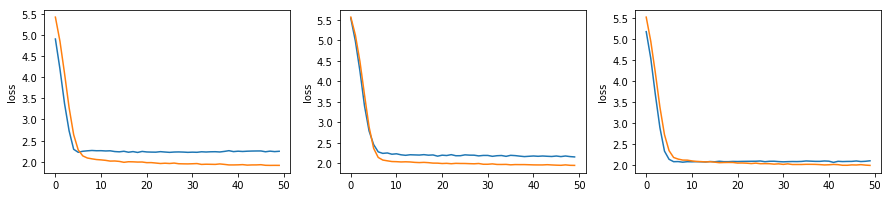

In [68]:
m_lineplot(df_his_list)

In [65]:
db.commit()